In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import ceil

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


from time import gmtime, strftime
from sklearn.decomposition import PCA
from sklearn import preprocessing
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.utils import shuffle

In [0]:
import os
import pretty_midi
from scipy.io import wavfile 
import IPython

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Dropout, Activation
from tensorflow.keras import backend as K
#from tensorflow.keras.layers import Dense, Conv2D, Flatten


from tensorflow.keras.layers  import Conv2D, ZeroPadding2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, History
#from tensorflow.keras.utils import model_to_dot
from tensorflow.train import RMSPropOptimizer, AdamOptimizer
from tensorflow.keras.callbacks import ReduceLROnPlateau


from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.utils.vis_utils import plot_model
#from IPython.display import SVG

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob


In [0]:
SEED = 1234
size_img = 56

In [4]:
"""
# If we want to download the files
!wget https://www.dropbox.com/s/486li09u91zyjdm/db_train.raw?dl=1
!wget https://www.dropbox.com/s/d2hsorvtla3rtf9/label_2019_train.txt?dl=1
!wget https://www.dropbox.com/s/qonk627t2557utz/db_val.raw?dl=1

!mv db_train.raw?dl=1 db_train.raw
!mv db_val.raw?dl=1 db_val.raw
!mv label_2019_train.txt?dl=1 label_2019_train.txt
"""


'\n# If we want to download the files\n!wget https://www.dropbox.com/s/486li09u91zyjdm/db_train.raw?dl=1\n!wget https://www.dropbox.com/s/d2hsorvtla3rtf9/label_2019_train.txt?dl=1\n!wget https://www.dropbox.com/s/qonk627t2557utz/db_val.raw?dl=1\n\n!mv db_train.raw?dl=1 db_train.raw\n!mv db_val.raw?dl=1 db_val.raw\n!mv label_2019_train.txt?dl=1 label_2019_train.txt\n'

In [0]:
# If we use the drive
#from google.colab import drive
#drive.mount('drive')

#print(os.listdir('drive/My Drive/Google Colab'))

# Loading and investigating the data

## Loading data

In [0]:
train_images_fname = 'drive/My Drive/Google Colab/Challenge_CNN/data/db_train.raw'
train_labels_fname = 'drive/My Drive/Google Colab/Challenge_CNN/data/label_2019_train.txt'

val_images_fname    = 'drive/My Drive/Google Colab/Challenge_CNN/data/db_val.raw'

test_image_fname    = 'drive/My Drive/Google Colab/Challenge_CNN/data/db_test.raw'



# number of images
num_train_images = 116157
num_valid_images = 27013
num_test_images = 59429


# size of the images 56*56 pixels in gray levels
image_dim = 56 * 56 * 3

train_images_label = np.loadtxt(train_labels_fname, dtype=np.float64)

with open(train_images_fname, 'rb') as f:
    train_images_data = np.fromfile(f, dtype=np.uint8, count=num_train_images * image_dim).astype(np.uint8)#float32
    train_images_data = train_images_data.reshape(num_train_images, 56,56,3)
    
with open(val_images_fname, 'rb') as f:
    val_images_data = np.fromfile(f, dtype=np.uint8, count=num_valid_images * image_dim).astype(np.uint8)
    val_images_data = val_images_data.reshape(num_valid_images, 56,56,3)
    
with open(test_image_fname, 'rb') as f:
    test_image_challenge = np.fromfile(f, dtype=np.uint8, count=num_test_images * image_dim).astype(np.uint8)
    test_image_challenge = test_image_challenge.reshape(num_test_images, 56,56,3)

In [7]:
# Investigation
print(train_images_data.shape)
print(train_images_label.shape)
print(val_images_data.shape)
print(test_image_challenge.shape)

(116157, 56, 56, 3)
(116157,)
(27013, 56, 56, 3)
(59429, 56, 56, 3)


## Split of the data

In [0]:
train_ratio = 0.98
train_size = ceil(num_train_images*0.8)
test_size = (num_train_images - train_size) // 2
dev_size = num_train_images - train_size - test_size


In [9]:
X_train = train_images_data[:train_size]
dev_x = train_images_data[train_size:(train_size+test_size)]
X_test = train_images_data[(train_size+test_size):]

y_train = train_images_label[:train_size]
dev_y = train_images_label[train_size:(train_size+test_size)]
y_test = train_images_label[(train_size+test_size):]

X_full = train_images_data
y_full =  train_images_label

print("X_train ", X_train.shape)
print("dev_x ", dev_x.shape)
print("X_test", X_test.shape)

print("y_train ", y_train.shape)
print("dev_y ", dev_y.shape)
print("y_test", y_test.shape)



X_train  (92926, 56, 56, 3)
dev_x  (11615, 56, 56, 3)
X_test (11616, 56, 56, 3)
y_train  (92926,)
dev_y  (11615,)
y_test (11616,)


## Visualising data

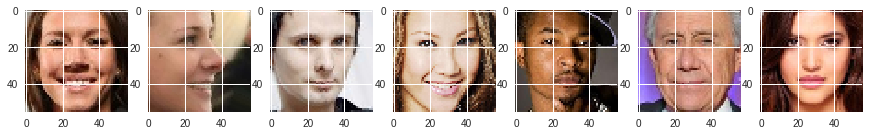

In [10]:


fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(15, 6))

for i, ax in enumerate(axes):
    ax.imshow(train_images_data[i].astype(np.uint8))


#  Prediction

We create a function to evaluate our model

In [0]:


# Performance measure
def compute_pred_score(y_true, y_pred):
    if(y_true.shape[0] != y_pred.shape[0]):
        raise Exception("y_pred and y_true must have the same size")
    tmp = np.unique(y_pred)
    if(tmp.shape[0] > 2):
        raise("y_pred should only contain 0 and 1")
        
    if(tmp.shape[0] == 1):
        if(tmp[0] != 0 and tmp[0] != 1):
            raise Exception("y_pred should only contain 0 and 1")
    else:
        if(tmp[0] != 0 and tmp[1] != 1):
            raise Exception("y_pred should only contain 0 and 1")
    
    y0 = (y_true == 0)
    y1 = (y_true == 1)
    
    acc1 = np.mean(1-y_pred[y0])
    acc2 = np.mean(y_pred[y1])
    
    return (acc1+acc2)/2


## Neural network

### Definition of the model

In [12]:
# create the model
K.clear_session()

history = History()


# We create our model and use a TPU for faster calculation
model = Sequential()

######## Sequencial implementation

model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(size_img,size_img,3), padding='same')) #enlever 2
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(64, kernel_size=5, activation='relu', padding='same')) # enlever 4 (5-1)
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=5, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=5, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(128, kernel_size=7, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=7, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=7, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=7, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(256, kernel_size=9, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=9, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=9, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=9, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))


model.add(Flatten())


model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))


model =  tf.contrib.tpu.keras_to_tpu_model(
   model,
   strategy=tf.contrib.tpu.TPUDistributionStrategy(
       tf.contrib.cluster_resolver.TPUClusterResolver(
           tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
   )
)


# --- END CODE HERE

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.21.101.50:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 1993172301137646400)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16703587194740552811)
INFO:tensorflow:*** Available Device: _DeviceAtt

### Schema of the model

In [0]:
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Run of the model

In [0]:
opt = Adam(lr=0.0001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

INFO:tensorflow:Cloning Adam {'lr': 9.999999747378752e-05, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}


In [0]:
model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=[dev_x, dev_y], callbacks=[history])
#validation_data=[dev_x, dev_y]

Train on 92926 samples, validate on 11615 samples
Epoch 1/30
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(8,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(8, 56, 56, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(8, 1), dtype=tf.float32, name='dense_3_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 9.999999747378752e-05, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for conv2d_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f10739acb38> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 21.290066957473755 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 9.999999747378752e-05 {1e-04}
INFO:tensorflow:CPU -> TPU beta_1: 0.8999999761581421 {0.9}
INFO:ten

### Plot of the model evolution

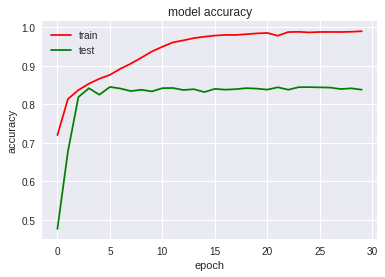

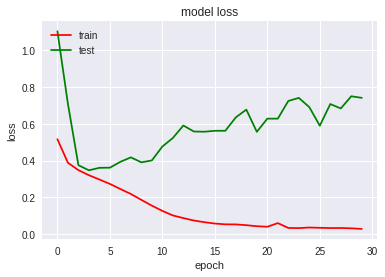

In [0]:
plt.plot(history.history['acc'],color = 'red')#linestyle = '--'
plt.plot(history.history['val_acc'], color = 'green')
plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(history.history['loss'],color = 'red')#linestyle = '--'
plt.plot(history.history['val_loss'], color = 'green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [0]:

    
layer_outputs = [layer.output for layer in model.layers[1:]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[11].reshape(1,56,56,3))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(15, 6))#figsize=(row_size*2.5,col_size*1.5)
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1
        

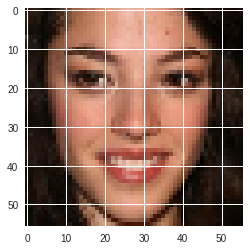

In [0]:

#plt.imshow(X_train[11][:,:,0])
plt.imshow(X_train[11].astype(np.uint8))


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


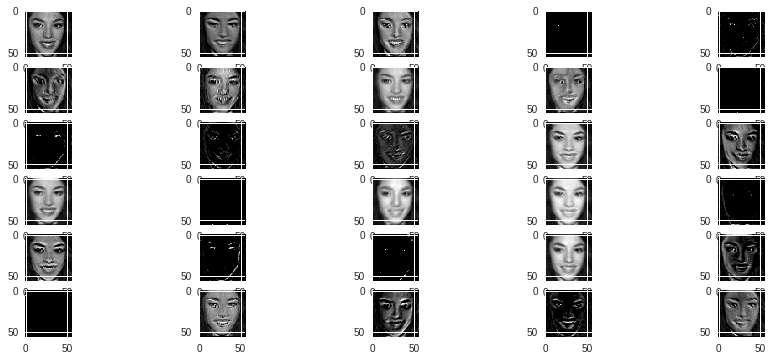

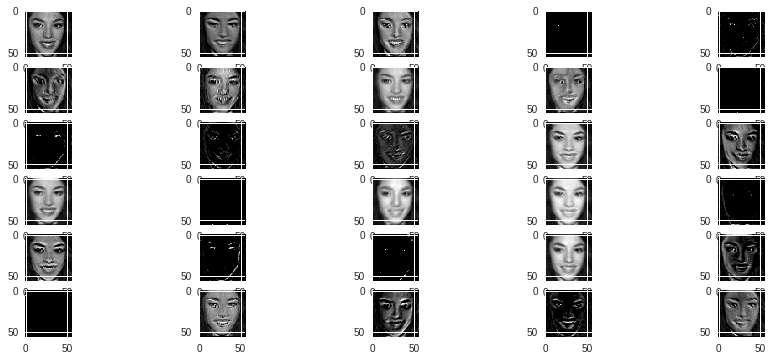

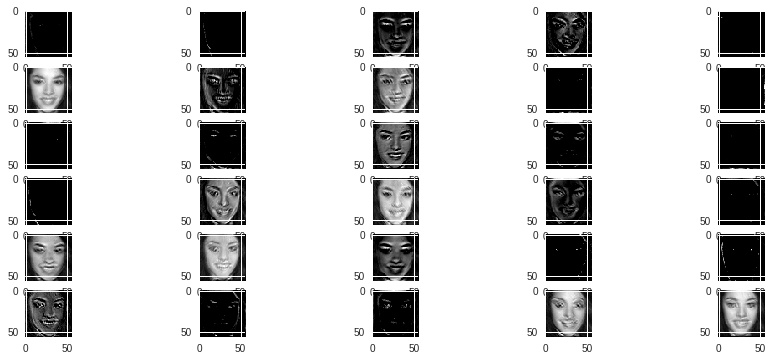

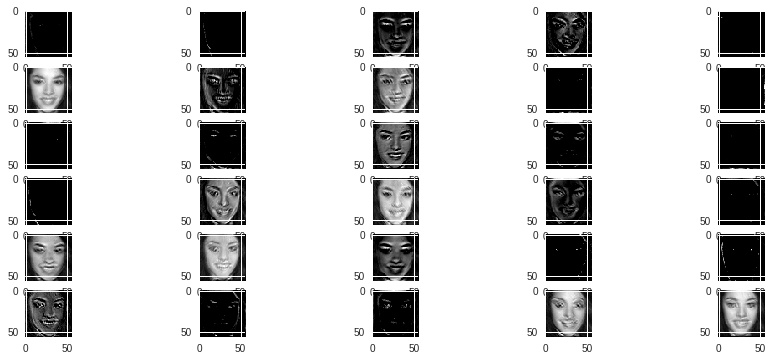

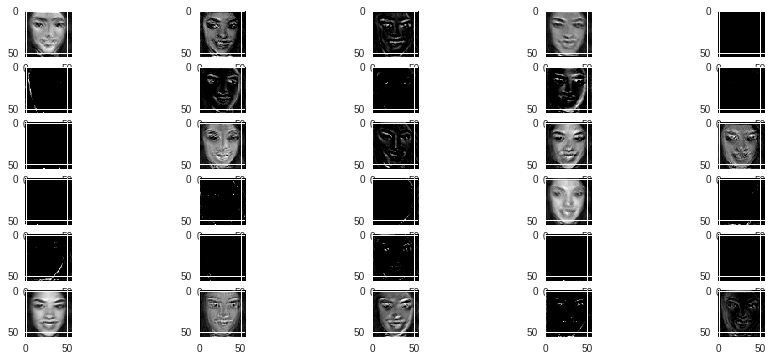

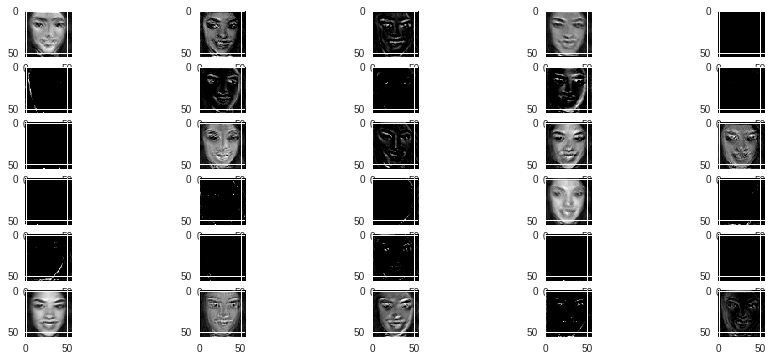

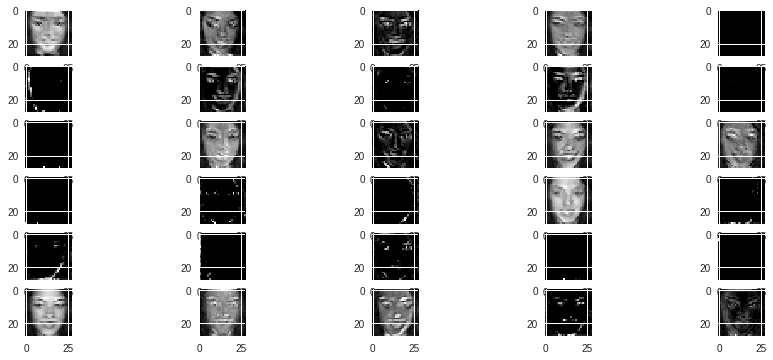

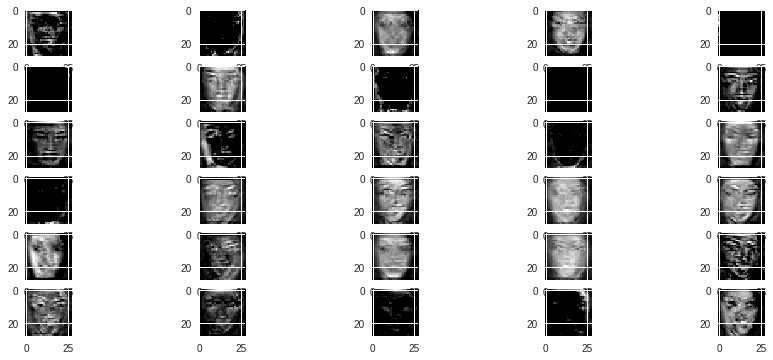

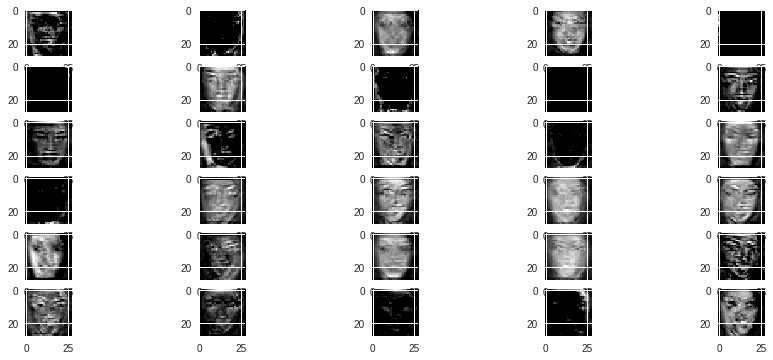

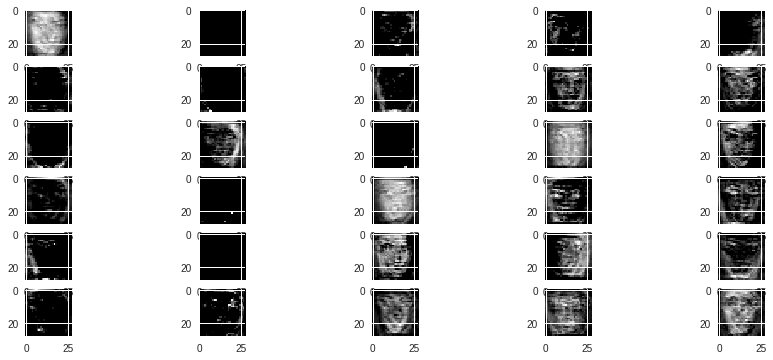

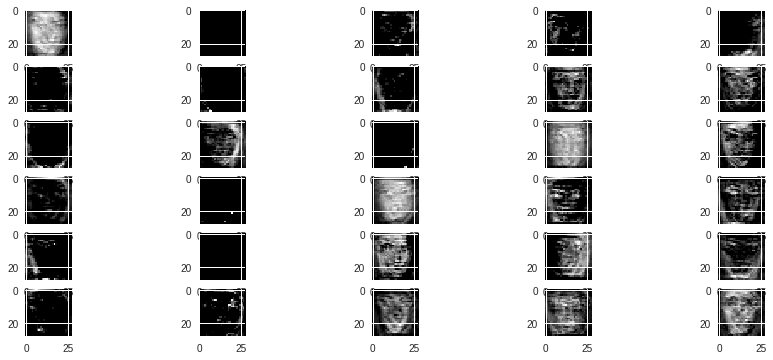

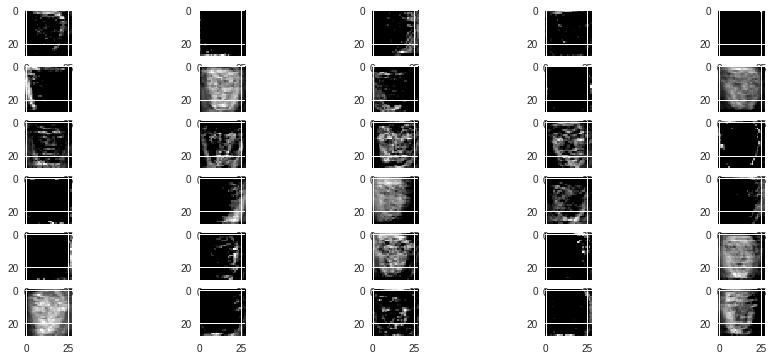

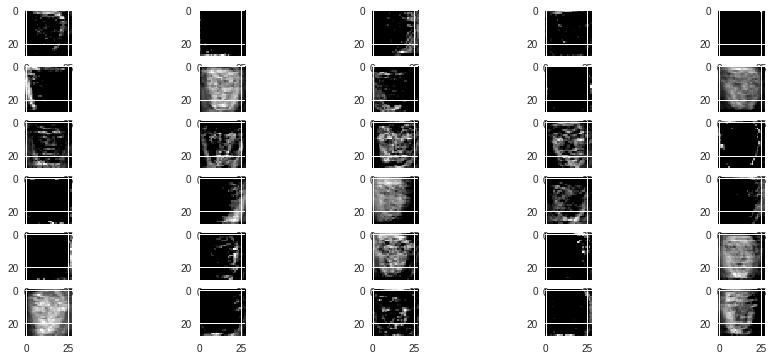

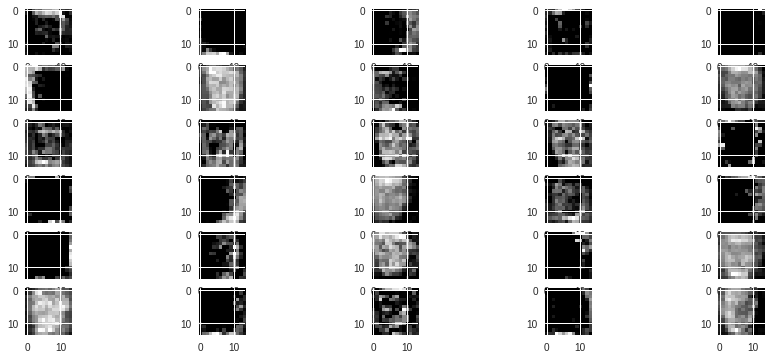

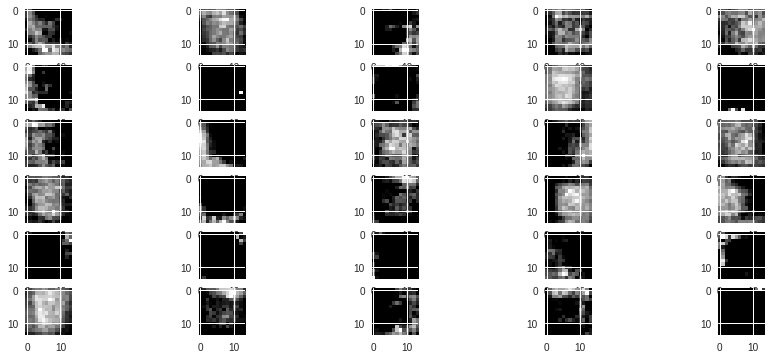

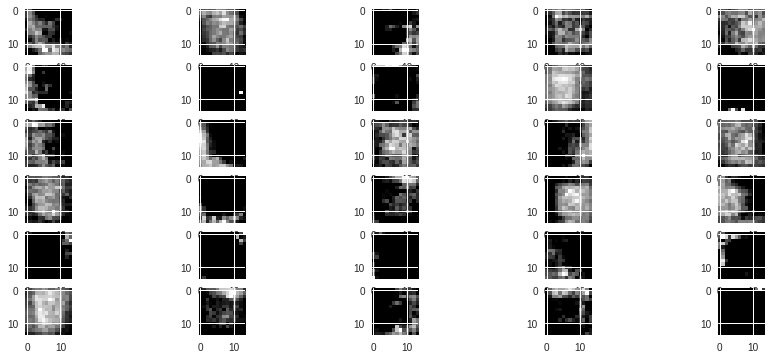

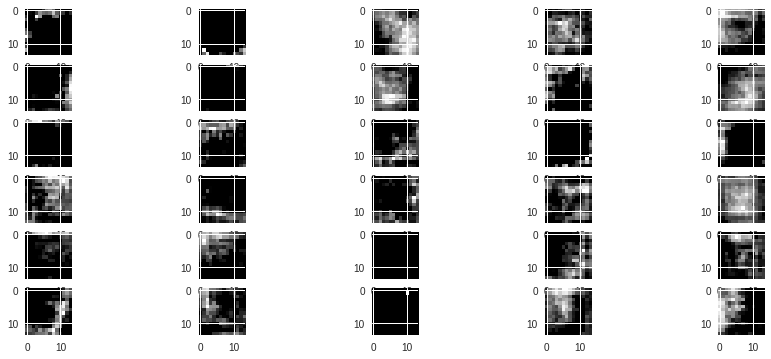

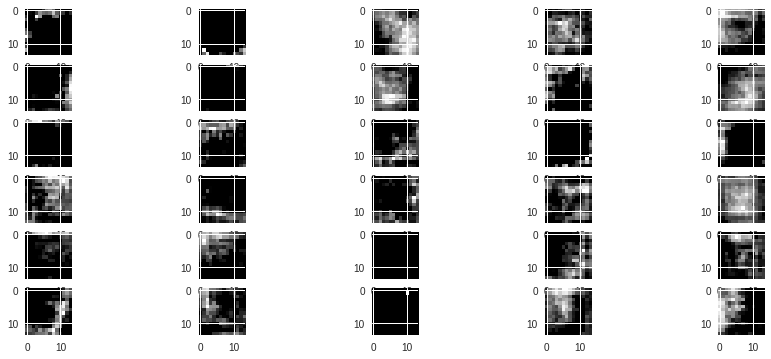

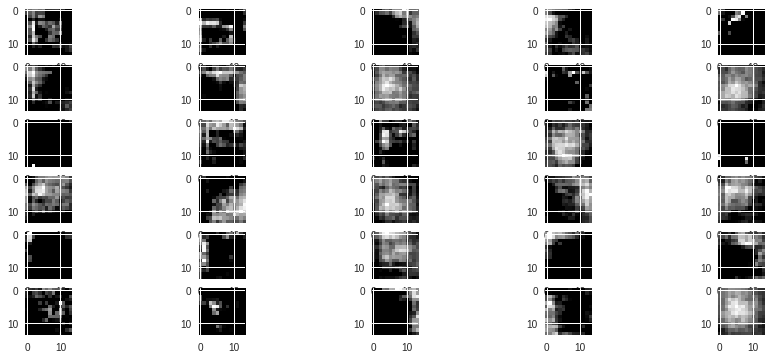

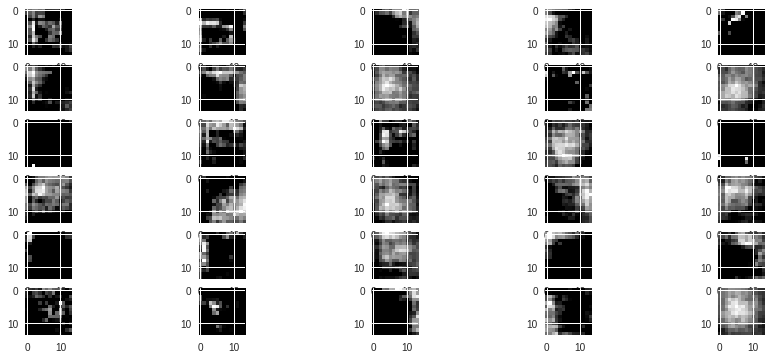

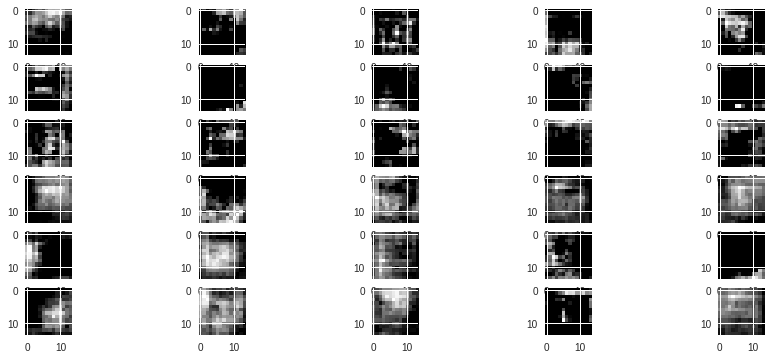

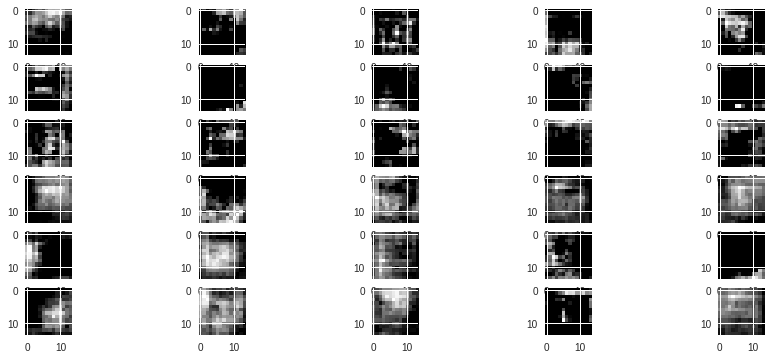

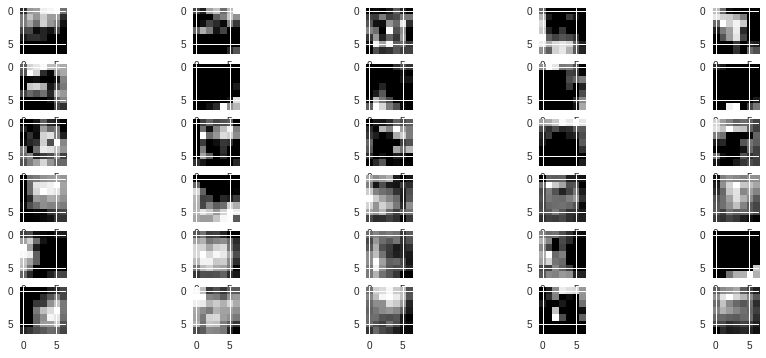

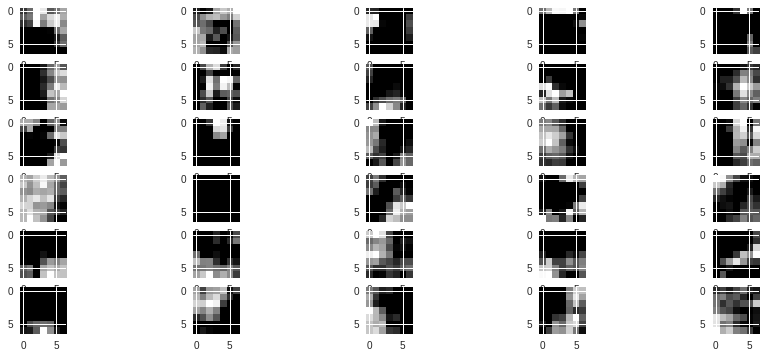

In [0]:
for i in range (len(layer_outputs)-16):
  #print("Layer ",i)
  activation = activations[i]
  
  display_activation(activations, 5, 6, i)

### Try of other models

#### Try 1 model simplier

In [0]:
# create the model
K.clear_session()

history2 = History()


# We create our model and use a TPU for faster calculation
model2 = Sequential()

######## Sequencial implementation

model2.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(size_img,size_img,3), padding='same')) #enlever 2
model2.add(BatchNormalization())
model2.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=2))

model2.add(Conv2D(64, kernel_size=5, activation='relu', padding='same')) # enlever 4 (5-1)
model2.add(BatchNormalization())
model2.add(Conv2D(64, kernel_size=5, activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=2))


model2.add(Flatten())


model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.3))

model2.add(Dense(1, activation='sigmoid'))


model2 =  tf.contrib.tpu.keras_to_tpu_model(
   model2,
   strategy=tf.contrib.tpu.TPUDistributionStrategy(
       tf.contrib.cluster_resolver.TPUClusterResolver(
           tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
   )
)


# --- END CODE HERE

print(model2.summary())

INFO:tensorflow:Querying Tensorflow master (grpc://10.92.162.58:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10248705926492010436)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 11500645400317436944)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 2765334847536785411)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 7121199792806991177)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 16150901627174550600)
INFO:tensorflow:*** Available Device: _DeviceAttributes

In [0]:
opt2 = Adam(lr=0.001)
model2.compile(loss='binary_crossentropy', optimizer=opt2, metrics=['accuracy'])


model2.fit(X_train, y_train, epochs=12, batch_size=64, validation_data=[dev_x, dev_y], callbacks=[history2])
#validation_data=[dev_x, dev_y]

INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
Train on 92926 samples, validate on 11615 samples
Epoch 1/12
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(8,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(8, 56, 56, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(8, 1), dtype=tf.float32, name='dense_5_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for conv2d_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f104f696240> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 8.209693670272827 secs
INFO:te

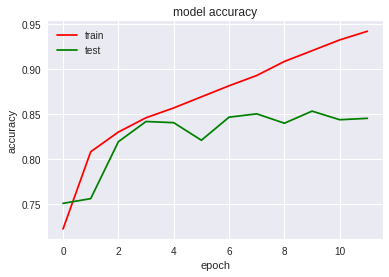

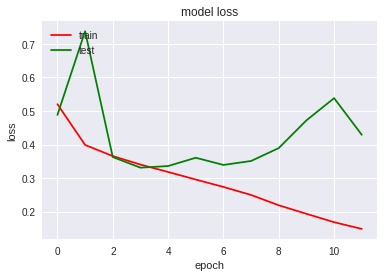

In [0]:
plt.plot(history2.history['acc'],color = 'red')#linestyle = '--'
plt.plot(history2.history['val_acc'], color = 'green')
plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(history2.history['loss'],color = 'red')#linestyle = '--'
plt.plot(history2.history['val_loss'], color = 'green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



#### Try 2: increase dropout

In [0]:
# create the model
K.clear_session()
history3 = History()



# We create our model and use a TPU for faster calculation
model3 = Sequential()

######## Sequencial implementation
#model3.add(BatchNormalization())
model3.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(size_img,size_img,3), padding='same')) #enlever 2
model3.add(BatchNormalization())
model3.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=2))


model3.add(Conv2D(64, kernel_size=5, activation='relu', padding='same')) # enlever 4 (5-1)
model3.add(BatchNormalization())
model3.add(Conv2D(64, kernel_size=5, activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=2))


model3.add(Flatten())


model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.4))

model3.add(Dense(1, activation='sigmoid'))


model3 =  tf.contrib.tpu.keras_to_tpu_model(
   model3,
   strategy=tf.contrib.tpu.TPUDistributionStrategy(
       tf.contrib.cluster_resolver.TPUClusterResolver(
           tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
   )
)


# --- END CODE HERE

print(model3.summary())

INFO:tensorflow:Querying Tensorflow master (grpc://10.92.162.58:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10248705926492010436)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 11500645400317436944)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 2765334847536785411)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 7121199792806991177)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 16150901627174550600)
INFO:tensorflow:*** Available Device: _DeviceAttributes

In [0]:
opt3 = Adam(lr=0.001)
model3.compile(loss='binary_crossentropy', optimizer=opt3, metrics=['accuracy'])


model3.fit(X_train, y_train, epochs=12, batch_size=64, validation_data=[dev_x, dev_y], callbacks=[history3])
#validation_data=[dev_x, dev_y]

INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
Train on 92926 samples, validate on 11615 samples
Epoch 1/12
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(8,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(8, 56, 56, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(8, 1), dtype=tf.float32, name='dense_5_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for conv2d_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f1054ff87b8> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 8.577633142471313 secs
INFO:te

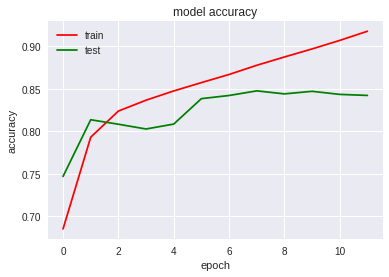

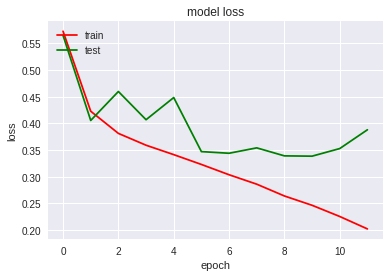

In [0]:
plt.plot(history3.history['acc'],color = 'red')#linestyle = '--'
plt.plot(history3.history['val_acc'], color = 'green')
plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(history3.history['loss'],color = 'red')#linestyle = '--'
plt.plot(history3.history['val_loss'], color = 'green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



#### Try 3: change increase batch size

In [0]:
# create the model
K.clear_session()

history4 = History()


# We create our model and use a TPU for faster calculation
model4 = Sequential()

######## Sequencial implementation

model4.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(size_img,size_img,3), padding='same')) #enlever 2
model4.add(BatchNormalization())
model4.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=2))

model4.add(Conv2D(64, kernel_size=5, activation='relu', padding='same')) # enlever 4 (5-1)
model4.add(BatchNormalization())
model4.add(Conv2D(64, kernel_size=5, activation='relu', padding='same'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=2))


model4.add(Flatten())


model4.add(Dense(512, activation='relu'))
model4.add(Dropout(0.3))
model4.add(Dense(512, activation='relu'))
model4.add(Dropout(0.3))
model4.add(Dense(512, activation='relu'))
model4.add(Dropout(0.3))
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.3))
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.3))

model4.add(Dense(1, activation='sigmoid'))


model4 =  tf.contrib.tpu.keras_to_tpu_model(
   model4,
   strategy=tf.contrib.tpu.TPUDistributionStrategy(
       tf.contrib.cluster_resolver.TPUClusterResolver(
           tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
   )
)


# --- END CODE HERE

print(model4.summary())

INFO:tensorflow:Querying Tensorflow master (grpc://10.92.162.58:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10248705926492010436)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 11500645400317436944)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 2765334847536785411)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 7121199792806991177)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 16150901627174550600)
INFO:tensorflow:*** Available Device: _DeviceAttributes

In [0]:
opt4 = Adam(lr=0.001)
model4.compile(loss='binary_crossentropy', optimizer=opt4, metrics=['accuracy'])


model4.fit(X_train, y_train, epochs=12, batch_size=128, validation_data=[dev_x, dev_y], callbacks=[history4])
#validation_data=[dev_x, dev_y]

INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
Train on 92926 samples, validate on 11615 samples
Epoch 1/12
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(16,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(16, 56, 56, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(16, 1), dtype=tf.float32, name='dense_5_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for conv2d_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f10465d20b8> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 9.199331998825073 secs
INFO

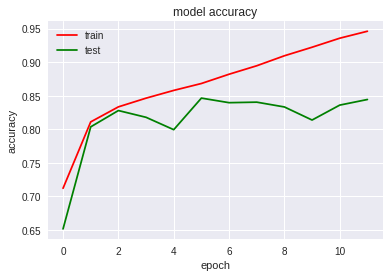

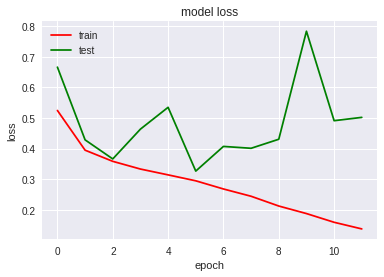

In [0]:
plt.plot(history4.history['acc'],color = 'red')#linestyle = '--'
plt.plot(history4.history['val_acc'], color = 'green')
plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(history4.history['loss'],color = 'red')#linestyle = '--'
plt.plot(history4.history['val_loss'], color = 'green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



#### Try 4: Decrease batch size

In [0]:
# create the model
K.clear_session()

history5 = History()


# We create our model and use a TPU for faster calculation
model5 = Sequential()

######## Sequencial implementation

model5.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(size_img,size_img,3), padding='same')) #enlever 2
model5.add(BatchNormalization())
model5.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=2))

model5.add(Conv2D(64, kernel_size=5, activation='relu', padding='same')) # enlever 4 (5-1)
model5.add(BatchNormalization())
model5.add(Conv2D(64, kernel_size=5, activation='relu', padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=2))


model5.add(Flatten())


model5.add(Dense(512, activation='relu'))
model5.add(Dropout(0.3))
model5.add(Dense(512, activation='relu'))
model5.add(Dropout(0.3))
model5.add(Dense(512, activation='relu'))
model5.add(Dropout(0.3))
model5.add(Dense(256, activation='relu'))
model5.add(Dropout(0.3))
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.3))

model5.add(Dense(1, activation='sigmoid'))


model5 =  tf.contrib.tpu.keras_to_tpu_model(
   model5,
   strategy=tf.contrib.tpu.TPUDistributionStrategy(
       tf.contrib.cluster_resolver.TPUClusterResolver(
           tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
   )
)


# --- END CODE HERE

print(model5.summary())

INFO:tensorflow:Querying Tensorflow master (grpc://10.92.162.58:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10248705926492010436)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 11500645400317436944)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 2765334847536785411)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 7121199792806991177)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 16150901627174550600)
INFO:tensorflow:*** Available Device: _DeviceAttributes

In [0]:
opt5 = Adam(lr=0.001)
model5.compile(loss='binary_crossentropy', optimizer=opt5, metrics=['accuracy'])


model5.fit(X_train, y_train, epochs=12, batch_size=32, validation_data=[dev_x, dev_y], callbacks=[history5])
#validation_data=[dev_x, dev_y]

INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
Train on 92926 samples, validate on 11615 samples
Epoch 1/12
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(4,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(4, 56, 56, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(4, 1), dtype=tf.float32, name='dense_5_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for conv2d_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f103c68b668> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 8.450226068496704 secs
INFO:te

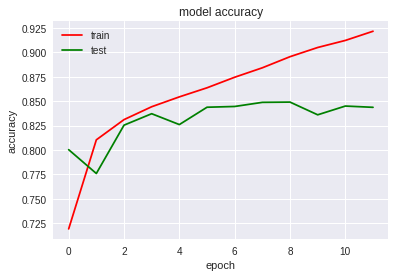

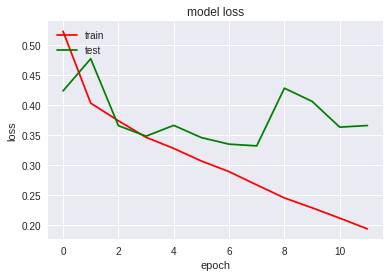

In [0]:
plt.plot(history5.history['acc'],color = 'red')#linestyle = '--'
plt.plot(history5.history['val_acc'], color = 'green')
plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(history5.history['loss'],color = 'red')#linestyle = '--'
plt.plot(history5.history['val_loss'], color = 'green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



#### Try 5 : increasing the learning rate

In [0]:
# create the model
K.clear_session()

history6 = History()


# We create our model and use a TPU for faster calculation
model6 = Sequential()

######## Sequencial implementation

model6.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(size_img,size_img,3), padding='same')) #enlever 2
model6.add(BatchNormalization())
model6.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D(pool_size=2))

model6.add(Conv2D(64, kernel_size=5, activation='relu', padding='same')) # enlever 4 (5-1)
model6.add(BatchNormalization())
model6.add(Conv2D(64, kernel_size=5, activation='relu', padding='same'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D(pool_size=2))


model6.add(Flatten())


model6.add(Dense(512, activation='relu'))
model6.add(Dropout(0.3))
model6.add(Dense(512, activation='relu'))
model6.add(Dropout(0.3))
model6.add(Dense(512, activation='relu'))
model6.add(Dropout(0.3))
model6.add(Dense(256, activation='relu'))
model6.add(Dropout(0.3))
model6.add(Dense(128, activation='relu'))
model6.add(Dropout(0.3))

model6.add(Dense(1, activation='sigmoid'))


model6 =  tf.contrib.tpu.keras_to_tpu_model(
   model6,
   strategy=tf.contrib.tpu.TPUDistributionStrategy(
       tf.contrib.cluster_resolver.TPUClusterResolver(
           tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
   )
)


# --- END CODE HERE

print(model6.summary())

INFO:tensorflow:Querying Tensorflow master (grpc://10.92.162.58:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10248705926492010436)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 11500645400317436944)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 2765334847536785411)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 7121199792806991177)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 16150901627174550600)
INFO:tensorflow:*** Available Device: _DeviceAttributes

In [0]:
opt6 = Adam(lr=0.01)
model6.compile(loss='binary_crossentropy', optimizer=opt6, metrics=['accuracy'])


model6.fit(X_train, y_train, epochs=12, batch_size=64, validation_data=[dev_x, dev_y], callbacks=[history6])
#validation_data=[dev_x, dev_y]

INFO:tensorflow:Cloning Adam {'lr': 0.009999999776482582, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
Train on 92926 samples, validate on 11615 samples
Epoch 1/12
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(8,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(8, 56, 56, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(8, 1), dtype=tf.float32, name='dense_5_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.009999999776482582, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for conv2d_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f10325db198> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 8.29396677017212 secs
INFO:tenso

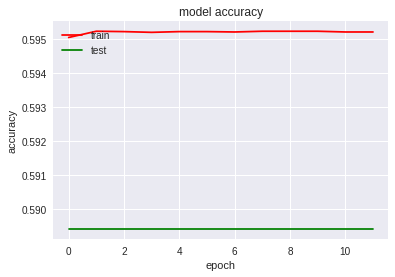

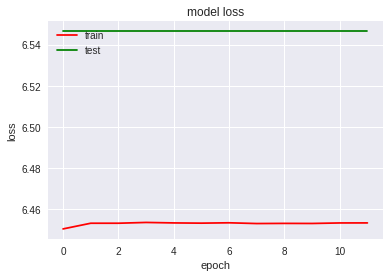

In [0]:
plt.plot(history6.history['acc'],color = 'red')#linestyle = '--'
plt.plot(history6.history['val_acc'], color = 'green')
plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(history6.history['loss'],color = 'red')#linestyle = '--'
plt.plot(history6.history['val_loss'], color = 'green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



#### Try 6: lowering the learning rate

In [0]:
# create the model
K.clear_session()

history7 = History()


# We create our model and use a TPU for faster calculation
model7 = Sequential()

######## Sequencial implementation

model7.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(size_img,size_img,3), padding='same')) #enlever 2
model7.add(BatchNormalization())
model7.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=2))

model7.add(Conv2D(64, kernel_size=5, activation='relu', padding='same')) # enlever 4 (5-1)
model7.add(BatchNormalization())
model7.add(Conv2D(64, kernel_size=5, activation='relu', padding='same'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=2))


model7.add(Flatten())


model7.add(Dense(512, activation='relu'))
model7.add(Dropout(0.3))
model7.add(Dense(512, activation='relu'))
model7.add(Dropout(0.3))
model7.add(Dense(512, activation='relu'))
model7.add(Dropout(0.3))
model7.add(Dense(256, activation='relu'))
model7.add(Dropout(0.3))
model7.add(Dense(128, activation='relu'))
model7.add(Dropout(0.3))

model7.add(Dense(1, activation='sigmoid'))


model7 =  tf.contrib.tpu.keras_to_tpu_model(
   model7,
   strategy=tf.contrib.tpu.TPUDistributionStrategy(
       tf.contrib.cluster_resolver.TPUClusterResolver(
           tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
   )
)


# --- END CODE HERE

print(model7.summary())

INFO:tensorflow:Querying Tensorflow master (grpc://10.92.162.58:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10248705926492010436)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 11500645400317436944)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 2765334847536785411)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 7121199792806991177)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 16150901627174550600)
INFO:tensorflow:*** Available Device: _DeviceAttributes

In [0]:
opt7 = Adam(lr=0.0001)
model7.compile(loss='binary_crossentropy', optimizer=opt7, metrics=['accuracy'])


model7.fit(X_train, y_train, epochs=12, batch_size=64, validation_data=[dev_x, dev_y], callbacks=[history7])
#validation_data=[dev_x, dev_y]

INFO:tensorflow:Cloning Adam {'lr': 9.999999747378752e-05, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
Train on 92926 samples, validate on 11615 samples
Epoch 1/12
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(8,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(8, 56, 56, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(8, 1), dtype=tf.float32, name='dense_5_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 9.999999747378752e-05, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for conv2d_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f102867c748> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 8.41249966621399 secs
INFO:ten

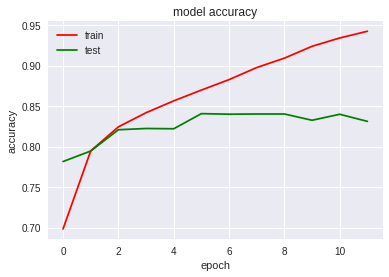

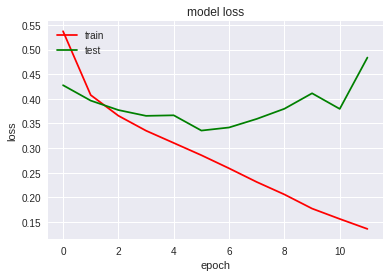

In [0]:
plt.plot(history7.history['acc'],color = 'red')#linestyle = '--'
plt.plot(history7.history['val_acc'], color = 'green')
plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(history7.history['loss'],color = 'red')#linestyle = '--'
plt.plot(history7.history['val_loss'], color = 'green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



#### Try 7: adding activation between convolutions

In [0]:
# create the model
K.clear_session()

history8 = History()


# We create our model and use a TPU for faster calculation
model8 = Sequential()

######## Sequencial implementation

model8.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(size_img,size_img,3), padding='same')) #enlever 2
model8.add(BatchNormalization())
model8.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model8.add(BatchNormalization())
model8.add(MaxPooling2D(pool_size=2))

model8.add(Activation("relu"))

model8.add(Conv2D(64, kernel_size=5, activation='relu', padding='same')) # enlever 4 (5-1)
model8.add(BatchNormalization())
model8.add(Conv2D(64, kernel_size=5, activation='relu', padding='same'))
model8.add(BatchNormalization())
model8.add(MaxPooling2D(pool_size=2))

model8.add(Activation("relu"))

model8.add(Flatten())


model8.add(Dense(512, activation='relu'))
model8.add(Dropout(0.3))
model8.add(Dense(512, activation='relu'))
model8.add(Dropout(0.3))
model8.add(Dense(512, activation='relu'))
model8.add(Dropout(0.3))
model8.add(Dense(256, activation='relu'))
model8.add(Dropout(0.3))
model8.add(Dense(128, activation='relu'))
model8.add(Dropout(0.3))

model8.add(Dense(1, activation='sigmoid'))


model8 =  tf.contrib.tpu.keras_to_tpu_model(
   model8,
   strategy=tf.contrib.tpu.TPUDistributionStrategy(
       tf.contrib.cluster_resolver.TPUClusterResolver(
           tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
   )
)


# --- END CODE HERE

print(model8.summary())

INFO:tensorflow:Querying Tensorflow master (grpc://10.92.162.58:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10248705926492010436)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 11500645400317436944)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 2765334847536785411)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 7121199792806991177)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 16150901627174550600)
INFO:tensorflow:*** Available Device: _DeviceAttributes

In [0]:
opt8 = Adam(lr=0.001)
model8.compile(loss='binary_crossentropy', optimizer=opt8, metrics=['accuracy'])


model8.fit(X_train, y_train, epochs=12, batch_size=64, validation_data=[dev_x, dev_y], callbacks=[history8])
#validation_data=[dev_x, dev_y]

INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
Train on 92926 samples, validate on 11615 samples
Epoch 1/12
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(8,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(8, 56, 56, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(8, 1), dtype=tf.float32, name='dense_5_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for conv2d_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f101ddab4a8> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 8.289215326309204 secs
INFO:te

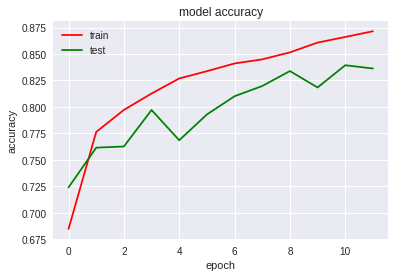

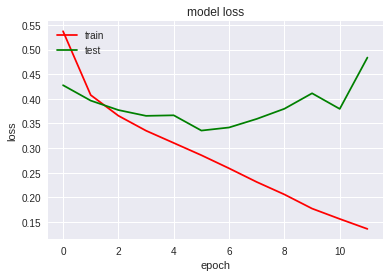

In [0]:
plt.plot(history8.history['acc'],color = 'red')#linestyle = '--'
plt.plot(history8.history['val_acc'], color = 'green')
plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(history7.history['loss'],color = 'red')#linestyle = '--'
plt.plot(history7.history['val_loss'], color = 'green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



### Comparison of the models

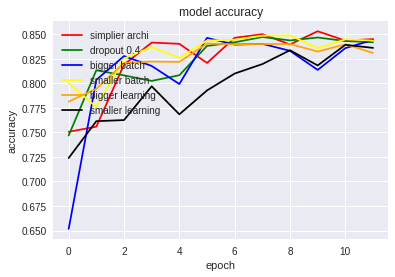

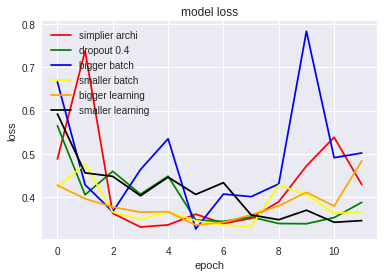

In [0]:
plt.plot(history2.history['val_acc'], color = 'red')
plt.plot(history3.history['val_acc'], color = 'green')
plt.plot(history4.history['val_acc'], color = 'blue')
plt.plot(history5.history['val_acc'], color = 'yellow')
#plt.plot(history6.history['val_acc'], color = 'pink')
plt.plot(history7.history['val_acc'], color = 'orange')
plt.plot(history8.history['val_acc'], color = 'black')

plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['simplier archi', 'dropout 0.4', 'bigger batch', 'smaller batch', 'smaller learning', 'activation between conv',], loc='upper left')
plt.legend(['simplier archi', 'dropout 0.4', 'bigger batch', 'smaller batch', 'bigger learning', 'smaller learning', 'activation between conv',], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(history2.history['val_loss'], color = 'red')
plt.plot(history3.history['val_loss'], color = 'green')
plt.plot(history4.history['val_loss'], color = 'blue')
plt.plot(history5.history['val_loss'], color = 'yellow')
#plt.plot(history6.history['val_loss'], color = 'pink')
plt.plot(history7.history['val_loss'], color = 'orange')
plt.plot(history8.history['val_loss'], color = 'black')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['simplier archi', 'dropout 0.4', 'bigger batch', 'smaller batch', 'smaller learning', 'activation between conv',], loc='upper left')
plt.legend(['simplier archi', 'dropout 0.4', 'bigger batch', 'smaller batch', 'bigger learning', 'smaller learning', 'activation between conv',], loc='upper left')
plt.show()



### Data augmentation

#### Creating the model

In [13]:
#FULL TRY

# create the model

K.clear_session()

history = History()


# We create our model and use a TPU for faster calculation
model = Sequential()

######## Sequencial implementation
model.add(BatchNormalization(input_shape=(size_img,size_img,3)))
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(size_img,size_img,3), padding='same',name="CONV1")) #enlever 2
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same',name="CONV2"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(64, kernel_size=5, activation='relu', padding='same',name="CONV3")) # enlever 4 (5-1)
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=5, activation='relu', padding='same',name="CONV4"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))


model.add(Flatten())


model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))


opt = AdamOptimizer(0.0001)
#opt.lr = 0.0001

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


model =  tf.contrib.tpu.keras_to_tpu_model(
   model,
   strategy=tf.contrib.tpu.TPUDistributionStrategy(
       tf.contrib.cluster_resolver.TPUClusterResolver(
           tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
   )
)


print(model.summary())

INFO:tensorflow:Querying Tensorflow master (grpc://10.21.101.50:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 1993172301137646400)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16703587194740552811)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 8730819780630478781)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 18247942477897954877)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 10478958664998055912)
INFO:tensorflow:*** Available Device: _DeviceAttributes

#### Defining the transformation to apply

In [0]:
datagenTrain = ImageDataGenerator(
        horizontal_flip=True)
datagenValid = ImageDataGenerator(
        horizontal_flip=True)


#### Applying the datageneration to our set & training

In [15]:


        
"""datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')"""

datagenTrain.fit(X_train)
datagenValid.fit(dev_x)


BATCH = 32
EPOCH = 12

#reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_lr=0.0001)

model.fit_generator(datagenTrain.flow(*shuffle(X_train, y_train), batch_size=BATCH), steps_per_epoch=X_train.shape[0]//(2*BATCH), epochs=EPOCH, validation_data=datagenValid.flow(*shuffle(dev_x, dev_y)), validation_steps=BATCH, callbacks=[history])




Epoch 1/12
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(4,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(4, 56, 56, 3), dtype=tf.float32, name='batch_normalization_v1_input_10'), TensorSpec(shape=(4, 1), dtype=tf.float32, name='dense_5_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for batch_normalization_v1_input
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 6.155009031295776 secs
INFO:tensorflow:Setting weights on TPU model.
1020/2904 [=========>....................] - ETA: 2:39 - loss: 0.6097 - acc: 0.6509INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(3,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(3, 56, 56, 3), dtype=tf.float32, name='batch_normalization_v1_input_10'), TensorSpec(sha

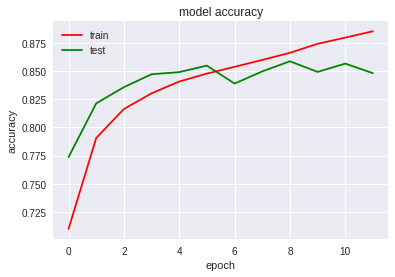

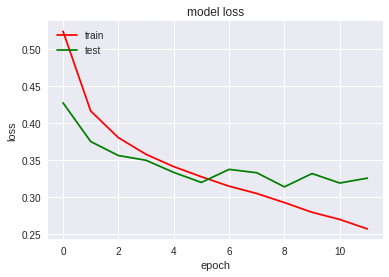

In [16]:
plt.plot(history.history['acc'],color = 'red')#linestyle = '--'
plt.plot(history.history['val_acc'], color = 'green')
plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(history.history['loss'],color = 'red')#linestyle = '--'
plt.plot(history.history['val_loss'], color = 'green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



### Saving the model

In [0]:
time = strftime("%Y-%m-%d_%H-%M", gmtime())

#model_plot = pd.DataFrame(history.history)
#model_plot.to_csv('drive/My Drive/Google Colab/Challenge_CNN/model_plot/model_plot_challenge_larrieu_valentin-'+time+'.csv')

model.save('drive/My Drive/Google Colab/Challenge_CNN/model/model_challenge_larrieu_valentin-'+time+'.h5')

### Training on the full set

In [0]:
#FULL TRY

# create the model

K.clear_session()

history = History()

# We create our model and use a TPU for faster calculation
model = Sequential()

######## Sequencial implementation
model.add(BatchNormalization(input_shape=(size_img,size_img,3)))
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(size_img,size_img,3), padding='same',name="CONV1")) #enlever 2
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same',name="CONV2"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(64, kernel_size=5, activation='relu', padding='same',name="CONV3")) # enlever 4 (5-1)
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=5, activation='relu', padding='same',name="CONV4"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))


model.add(Flatten())


model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))


opt = AdamOptimizer(0.0001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


model =  tf.contrib.tpu.keras_to_tpu_model(
   model,
   strategy=tf.contrib.tpu.TPUDistributionStrategy(
       tf.contrib.cluster_resolver.TPUClusterResolver(
           tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
   )
)


# --- END CODE HERE

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.50.224.170:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2324466035613197550)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1398476151514048099)
INFO:tensorflow:*** Available Device: _DeviceAtt

In [0]:
datagenTrain = ImageDataGenerator(
        horizontal_flip=True)
datagenValid = ImageDataGenerator(
        horizontal_flip=True)

#rescale=1./255

In [0]:



datagenTrain.fit(X_train)
#datagenValid.fit(dev_x)


#model.fit_generator(datagenTrain.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=[dev_x, dev_y], callbacks=[history])
BATCH = 32
EPOCH = 8

model.fit_generator(datagenTrain.flow(*shuffle(X_full, y_full), batch_size=BATCH), steps_per_epoch=X_full.shape[0]//(2*BATCH), epochs=EPOCH)




Epoch 1/8
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(4,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(4, 56, 56, 3), dtype=tf.float32, name='batch_normalization_v1_input_10'), TensorSpec(shape=(4, 1), dtype=tf.float32, name='dense_5_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for batch_normalization_v1_input
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.9246580600738525 secs
INFO:tensorflow:Setting weights on TPU model.
 614/3630 [====>.........................] - ETA: 4:44 - loss: 0.6545 - acc: 0.6216INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(3,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(3, 56, 56, 3), dtype=tf.float32, name='batch_normalization_v1_input_10'), TensorSpec(sha

## Generating the prediction

In [0]:
# Convert back the model in CPU for prediction (if not, we get an error of batchsize need to be a multiple of TPU cores)
model = model.sync_to_cpu()


INFO:tensorflow:Copying TPU weights to the CPU


In [0]:
#y_soft = model.predict(Xval_inputs, verbose = 1, batch_size = 10000)

pred = model.predict(X_test)
pred = (pred > 0.5) * 1.0

acc_train = compute_pred_score(y_test, pred)
print('The score on the training data : %s' % acc_train)

The score on the training data : 0.8653721195992157


## Saving the prediction

In [0]:
time = strftime("%Y-%m-%d_%H-%M", gmtime())

# Generate the prediction
val_pred = model.predict(test_image_challenge)
val_pred = (val_pred > 0.5) * 1.0

np.savetxt('drive/My Drive/Google Colab/Challenge_CNN/output/val_pred_challenge_larrieu_valentin-'+time+'.txt', val_pred, fmt="%d")



In [0]:
#When we work on google colab, we need to get our data back

#from google.colab import files

In [0]:
#files.download('val_pred_challenge_larrieu_valentin-'+time+'.txt')
